# Spark optimisation
![footer_logo_new](images/logo_new.png)

In [ ]:
from pyspark import StorageLevel
from pyspark.sql import functions as F, SQLContext, SparkSession, Window
from pyspark.sql.types import*
from random import randint
import time
import datetime

In [ ]:
spark = (SparkSession.builder
         .appName("workshop-spark-optimisation")
         .master("spark://spark-master:7077")
         .config("spark.eventLog.enabled", "true")
         .config("spark.eventLog.dir", "/opt/workspace/history")
         .config("spark.speculation", "false")  # when some task takes more than average time, speculation executor will be launched 
         .enableHiveSupport()
         .getOrCreate()
         )

In [ ]:
meteo_data_file = "data/meteo-data/parquet"
stations_meta_file = "data/meteo-data/stations.csv"
observation_type_file = "data/meteo-data/observation_type.csv"
flag_description_file = "data/meteo-data/flag_description.csv"

## Initialize dataframes

## Meteo observations

In [ ]:
def init_meteo_df():
    return spark.read.parquet(meteo_data_file)

### Stations dictionary

In [ ]:
def init_stations_df():
    schema = StructType([
        StructField('station_identifier', StringType(), True),
        StructField('latitude', FloatType(), True),
        StructField('longitude', FloatType(), True),
        StructField('height_above_sea_level', FloatType(), True),
        StructField('station_name', StringType(), True)
    ])
    return spark.read.schema(schema).option("header", "false").csv(stations_meta_file)

### Dictionary of observation types

In [ ]:
def init_observation_type_df():
    schema = StructType([
        StructField('observation_type', StringType(), True),
        StructField('description', StringType(), True)
    ])
    return spark.read.schema(schema).option("header", "false").csv(observation_type_file)

### Meteo flags dictionary

In [ ]:
def init_flag_description_df():
    schema = StructType([
        StructField('flag', StringType(), True),
        StructField('flag_description', StringType(), True),
        StructField('value', StringType(), True),
        StructField('value_description', StringType(), True)
    ])
    return spark.read.schema(schema).option("header", "false").csv(flag_description_file)

In [ ]:
meteo_df = init_meteo_df()
meteo_df.printSchema()
stations_df = init_stations_df()
stations_df.printSchema()

observation_type_df = init_observation_type_df()
observation_type_df.printSchema()

flag_description_df = init_flag_description_df()
flag_description_df.printSchema()

## Query optimization examples

### 1.Partition and predicate filters
Here are two examples that are fetching the same set of data, but in second case we add a partiton filter.
To know the size of your dataset use `df.cache().count()` and check Storage tab on Spark UI.
To see how the table is partitioned, use `spark.sql("DESCRIBE EXTENDED table").show()` for hive tables.

For this example The size of data that is fetched differs from 7.9 GB to 0.9 GB

In [ ]:
df1 = (meteo_df
       .where("station_identifier = 'AG000060390'")
       .where(F.year("date") >= '1991')
       .where(F.year("date") <= '2000')
      )
count = df1.cache().count()
print(count)
df1.unpersist()

In [ ]:
df1 = (meteo_df
       .where("station_identifier = 'AG000060390'")
       .where("yyyy >= 1991")
       .where("yyyy <= 2000")
      )
count = df1.cache().count()
print(count)
df1.unpersist()

### 2.Early filtering and selecting only necessary columns
At first example Spark makes full table  scan 7.9 GiB, while the second example selects only specific columns Spark scans 4.6 GiB

When the table has a lot of columns, selecting only specific columns as soon as possible can make a huge difference in processing time

In [ ]:
df1 = (meteo_df
       .where("station_identifier = 'AG000060390'")
       .where("observation_type = 'TAVG'")
      )
count = df1.cache().count()
print(count)

In [ ]:
df1.unpersist()

In [ ]:
df1 = (meteo_df
       .where("station_identifier = 'AG000060390'")
       .where("observation_type = 'TAVG'")
       .select("date", "QFLAG1")
      )
count = df1.cache().count()
print(count)

In [ ]:
df1.unpersist()

### 3. Shuffle partitions
If partition size is too large and doesn't fit into memory, Spill to Memory and to Disk might occur. In most cases increasing the number of shuffle partitions can speed up the execution of a job. Be aware, too many shuffle partitions generate extra pressure on driver.

In [ ]:
# persist a df to speed up a demo and also a good example if you need to use df multiple times 
df1 = (meteo_df
       .where("yyyy >=2018"))
df1.cache().count()

In [ ]:
# when running check spill on disk and memory
# in this example actual numbers seem small, it's just for the sake of example
spark.sql("SET spark.sql.shuffle.partitions=50")
df2 = df1.join(stations_df,meteo_df["station_identifier"] == stations_df["station_identifier"], "inner")
count = df2.cache().count()
print(count)

In [ ]:
df2.unpersist()

In [ ]:
spark.sql("SET spark.sql.shuffle.partitions=200")
df2 = df1.join(stations_df,meteo_df["station_identifier"] == stations_df["station_identifier"], "inner")
count = df2.cache().count()
print(count)

In [ ]:
df2.unpersist()

In [ ]:
# increasing number of shuffle partitions may lead to longer execution time
# run this in background to see what will happen 
'''
spark.sql("SET spark.sql.shuffle.partitions=300")
df2 = df1.join(stations_df,meteo_df["station_identifier"] == stations_df["station_identifier"], "inner")
count = df2.cache().count()
print(count)
df2.unpersist()
'''

In [ ]:
df1.unpersist()
spark.sql("SET spark.sql.shuffle.partitions=200")

**Ideally number of partitions should not be smaller than mumber of executors times cores**

### 4. Memory problems
Memory problems are the most common type of errors that you can get with Spark. We'll have a look on two examples: driver memory limit and executor memory limit.

Try to have a look and identify problems.

In [ ]:
df1 = (meteo_df
       .where("yyyy >=2018"))
df1.collect()

In [ ]:
df1 = meteo_df.where("observation_type == 'TAVG'").withColumn("month", F.month(meteo_df["date"])).withColumn("day", F.dayofmonth(meteo_df["date"]))
df2 = meteo_df.where("observation_type == 'TMIN'").withColumn("month", F.month(meteo_df["date"])).withColumn("day", F.dayofmonth(meteo_df["date"]))

df_res = (df1
          .join(F.broadcast(df2), (
              (df1["station_identifier"] == df2["station_identifier"]) &
              (df1["month"] == df2["month"]) & 
              (df1["day"] == df2["day"])
          ), "left")
         )
df_res.count()

Although broadcast can be useful to speed up a Spark job, you should be careful with the size of dataset you're working with  

### 5. UDF's

- UDF (user defined function) is a column-based function that extend the vocabulary of Spark SQL’s DSL.


- There are some cases when you can’t avoid using UDF’s: - when logic of transformations is so complex that you want to make a separate testable module out of it; - when no corresponding Spark DSL/SQL function exists.


- Spark uses internal optimization mechanisms called Tungsten and Catalyst. When you use UDFs, you’re losing support from these mechanisms.


- In case of PySpark API, you have Python process spawned together with Spark Worker process. Worker process serialized data and sends to Python process in order to run Python native function (UDF) against a partition. As you can imagine, this approach is way less efficient than Spark native.

Here are two examples, one is using User-Defined Functions and the other one using Spark Native Functions to achieve same goal.


In [ ]:
## Block 8

def addStationUDF(s):
  if s is None :
    return None
  else :
    return s + ' station'

def lowerUDF(s):
  if s is None :
    return None
  else :
    return s.lower()

def upperUDF(s):
  if s is None :
    return None
  else :
    return s.upper()

# temperature is measured in tenths of degrees C, we want to convert it to degrees C  
def valueConvertorUDF(observation_type, observation_value):
  if observation_type is None :
    return None    
  elif observation_type == "TMAX":
    return observation_value * 10;
  else :
    return observation_value;


spark.udf.register("addStationUDF", addStationUDF)
spark.udf.register("lowerUDF", lowerUDF)
spark.udf.register("upperUDF", upperUDF)
spark.udf.register("valueConvertorUDF", valueConvertorUDF)

In [ ]:
meteo_df.registerTempTable("meteo_table")

df_udf = spark.sql("""
                    select 
                       addStationUDF(station_identifier) as standard_station_identifier
                       , observation_type
                       , valueConvertorUDF(observation_type, observation_value) as normilized_observation_value 
                       , lowerUDF(station_identifier) as lower_station_name
                       , upperUDF(station_identifier) as upper_station_name
                    from 
                        meteo_table
                    where station_identifier = 'AG000060390'
                    and yyyy >= 2000
                """)

df_udf.explain(mode='formatted')

In [ ]:
df_udf.cache().count()
df_udf.unpersist()

Now, let's try to do same transformation with Spark Native functions.

In [ ]:
df_native = spark\
                .table("meteo_table")\
                .where("station_identifier = 'AG000060390'")\
                .where("yyyy >= 2000")\
                .select(F.col("station_identifier"), F.col("observation_type"), F.col("observation_value"), \
                        F.concat(F.col("station_identifier"), F.lit(" station")).alias("standard_station_identifier"),\
                        F.upper(F.col("station_identifier")).alias("upper_station_identifier"),\
                        F.lower(F.col("station_identifier")).alias("lower_station_identifier"))
                    
df_native = df_native.withColumn('normilized_observation_value', F.when((F.col("observation_type") == "TMAX")
    , F.col("observation_value") * 10).otherwise(F.col("observation_value")))
df_native = df_native.drop("observation_value")

df_native.explain(mode='formatted')

In [ ]:
df_native.cache().count()
df_native.unpersist()

### 6. Impact of data formats
**IMPORTANT** To run this example you need a csv dataset which is not present in instruqt env 


It is important to know the difference between formats, that are used to store data. If it's possible always store data in the most optimal format for operations you perform 

In [ ]:
meteo_data_file_csv = 'data/meteo-data/csv'
meteo_data_file_parquet = 'data/meteo-data/parquet'

parquet_df = spark.read.parquet(meteo_data_file_parquet)

schema = StructType([
    StructField('station_identifier', StringType(), True),
    StructField('date', StringType(), True),
    StructField('observation_type', StringType(), True),
    StructField('observation_value', IntegerType(), True),
    StructField('MFLAG1', StringType(), True), 
    StructField('QFLAG1', StringType(), True), 
    StructField('SFLAG1', StringType(), True), 
    StructField('time', StringType(), True), 
])
csv_df = (spark.read
         .schema(schema)
        .option("header", "false")
        .csv(meteo_data_file_csv))

In [ ]:
parquet_df\
    .where("station_identifier = 'AG000060390'")\
    .where("observation_type = 'TAVG'")\
    .where(F.year("date") == '2010')\
    .count()

In [ ]:
csv_df\
    .where("station_identifier = 'AG000060390'")\
    .where("observation_type = 'TAVG'")\
    .where(F.year("date") == '2010')\
    .count()

### 7. Executor memory and cores

It's important to find an optimal number of executors and cores to use all available resource as efficient as possible.
For this we need to recreate a sprak session.

NB: don't forget to restart env with approproate number of executors (see README) if working with Docker! 

In [ ]:
spark.stop()
spark = (SparkSession.builder
         .appName("workshop-spark-optimisation")
         .master("spark://spark-master:7077")
         .config("spark.eventLog.enabled", "true")
         .config("spark.eventLog.dir", "/opt/workspace/history")
         .config("spark.executor.cores", "1")
         .config("spark.executor.memory", "1G")
         .enableHiveSupport()
         .getOrCreate()
         )
df = spark.read.parquet(meteo_data_file)
df.where("station_identifier = 'AG000060390' and yyyy>2000").cache().count()
# 40 sec 

In [ ]:
spark.stop()
spark = (SparkSession.builder
         .appName("workshop-spark-optimisation")
         .master("spark://spark-master:7077")
         .config("spark.eventLog.enabled", "true")
         .config("spark.eventLog.dir", "/opt/workspace/history")
         .config("spark.executor.cores", "1")
         .config("spark.executor.memory", "2G")
         .enableHiveSupport()
         .getOrCreate()
         )
df = spark.read.parquet(meteo_data_file)
df.where("station_identifier = 'AG000060390' and yyyy>2000").cache().count()
# 40 sec 

In [ ]:
spark.stop()
spark = (SparkSession.builder
         .appName("workshop-spark-optimisation")
         .master("spark://spark-master:7077")
         .config("spark.eventLog.enabled", "true")
         .config("spark.eventLog.dir", "/opt/workspace/history")
         .config("spark.executor.cores", "4")
         .config("spark.executor.memory", "1G")
         .enableHiveSupport()
         .getOrCreate()
         )
df = spark.read.parquet(meteo_data_file)
df.where("station_identifier = 'AG000060390' and yyyy>2000").cache().count()
# 28 sec

In [ ]:
spark.stop()
spark = (SparkSession.builder
         .appName("workshop-spark-optimisation")
         .master("spark://spark-master:7077")
         .config("spark.eventLog.enabled", "true")
         .config("spark.eventLog.dir", "/opt/workspace/history")
         .config("spark.executor.cores", "4")
         .config("spark.executor.memory", "2G")
         .enableHiveSupport()
         .getOrCreate()
         )
df = spark.read.parquet(meteo_data_file)
df.where("station_identifier = 'AG000060390' and yyyy>2000").cache().count()
# 28 sec

But what if we have shuffle operation? 

In [ ]:
spark.stop()
spark = (SparkSession.builder
         .appName("workshop-spark-optimisation")
         .master("spark://spark-master:7077")
         .config("spark.eventLog.enabled", "true")
         .config("spark.eventLog.dir", "/opt/workspace/history")
         .config("spark.executor.cores", "4")
         .config("spark.executor.memory", "1G")
         .enableHiveSupport()
         .getOrCreate()
         )
df = spark.read.parquet(meteo_data_file)
df.where("yyyy>2000 and yyyy<=2010").groupBy("station_identifier", "observation_type", "yyyy").max("observation_value").cache().show(10)
# 1,2 min

In [ ]:
spark.stop()
spark = (SparkSession.builder
         .appName("workshop-spark-optimisation")
         .master("spark://spark-master:7077")
         .config("spark.eventLog.enabled", "true")
         .config("spark.eventLog.dir", "/opt/workspace/history")
         .config("spark.executor.cores", "4")
         .config("spark.executor.memory", "2G")
         .enableHiveSupport()
         .getOrCreate()
         )
df = spark.read.parquet(meteo_data_file)
df.where("yyyy>2000 and yyyy<=2010 and observation_type='TAVG'").groupBy("station_identifier", "yyyy").max("observation_value").cache().show(10)
# 20 s

In [ ]:
spark.stop()

### 8. Joins 

There are multiple types of join operations that you can use: 
- Shuffle hash join
- Sort merge join 
- Broadcast hash join 
- Cartesian join        
    

#### 8.1 Shuffle hash join 

The most basic type of joins, basically Map Reduce:
- Map through two data frames/tables
- use the field of join condition as an output key
- shuffle both datasets by the output key 
- as reduce step join the rows from both datasets with the same key (they are on the same machine and sorted)

Works best when DF: 
- destributed evently with the key (which we're joining on) 
- has an adequate number of keys to parallelise 
- one side (at least 3 times) larger than another. Then building hash table is faster than sorting data 

**Potentianlly might be fast if data is not skewed (because of avioding sorting stage). If data is skewed, it fails with OOM because partition should fit into memory**


In [ ]:
spark = (SparkSession.builder
         .appName("workshop-spark-optimisation")
         .master("spark://spark-master:7077")
         .config("spark.eventLog.enabled", "true")
         .config("spark.eventLog.dir", "/opt/workspace/history")
         .config("spark.executor.cores", "2")
         .enableHiveSupport()
         .getOrCreate()
         )

meteo_df = init_meteo_df()
stations_df = init_stations_df()
observation_type_df = init_observation_type_df()
flag_description_df = init_flag_description_df()


In [ ]:
spark.sql("SET spark.sql.join.preferSortMergeJoin=false") # true by default since 2.3
spark.sql("SET spark.sql.autoBroadcastJoinThreshold=100")

# By default Spark tries to avoid Shuffle Hash Join, there are conditions when Spark will do this type of join:
# 1. single partition should be small enough to build a hash table
# 2. one side of the join is much smaller than other
# 3. spark.sql.join.preferSortMergeJoin=false
# link to source code https://github.com/apache/spark/blob/branch-2.4/sql/core/src/main/scala/org/apache/spark/sql/execution/SparkStrategies.scala#L260

df1 = (meteo_df
         .where("observation_type in ('SNOW', 'TAVG')")
         .where("yyyy >2010")
      )
# we have only two keys to join on 
df2 = df1.join(observation_type_df,"observation_type", "inner")

df2.explain(mode='formatted')
df2.count()
df2.unpersist()
# We're not going to wait till it finishes

In [ ]:
spark.sql("SET spark.sql.join.preferSortMergeJoin=false") # true by default since 2.3
spark.sql("SET spark.sql.autoBroadcastJoinThreshold=100") # disable broadcast because spark is smart 
df2.unpersist()
df2 = (meteo_df
           .where("yyyy>2010")
           .join(observation_type_df,"observation_type", "inner")
           .cache()
           .where("observation_type in ('SNOW', 'TAVG')")
      )

df2.explain(mode='formatted')
df2.cache().count()
# see that shuffle stage is more even
df2.unpersist()

In [ ]:
spark.sql("SET spark.sql.join.preferSortMergeJoin=false") # true by default since 2.3
spark.sql("SET spark.sql.autoBroadcastJoinThreshold=200") # disable broadcast because spark is smart 

# create more keys 
df1 = (meteo_df
         .where("observation_type in ('SNOW', 'TAVG')")
         .where("yyyy>2010")
         .withColumn("observation_type_new", F.concat(F.col("observation_type"), (F.rand()*10).cast('int')))
      )

arr = [f"SNOW{n}" for n in range(1, 11)] + [f"TAVG{n}" for n in range(1, 11)] 
df_temp = (observation_type_df
                .where("observation_type in ('SNOW', 'TAVG')")
                .withColumn("tag_array", F.array([F.lit(x) for x in arr]))
                .withColumn("observation_type_new",  F.explode(F.col("tag_array")))
                .filter(F.col("observation_type_new").contains(F.col("observation_type")))
                .drop("tag_array")
          )
df2 = df1.join(df_temp,"observation_type_new", "inner").drop("observation_type_new")
df2.explain(mode='formatted')
# df2.cache().count()
## see that shuffle stage is more even
## We'll focus on unequal destibuted keys in Data skew section 
df2.unpersist()

#### 8.2 Sort Merge Join

Sort-merge join is composed of 2 steps:
- ordering operation made on 2 joined datasets;
- the merge of sorted data into a single place by simply iterating over the elements and assembling the rows having the same value for the join key.



In [ ]:
spark.sql("SET spark.sql.join.preferSortMergeJoin=true") # enabled by default 
spark.sql("SET spark.sql.autoBroadcastJoinThreshold=0")

meteo_df.unpersist()
df2.unpersist()

df1 = (meteo_df
         .where("observation_type in ('SNOW', 'TAVG')")
         .where("yyyy>2010")
      )
df2 = df1.join(observation_type_df,"observation_type", "inner")

df2.explain(mode='formatted')
df2.count()
# df2.cache().count()

# For skew data it will not fail with OOM because data will be just spilled to disk 
df2.unpersist()

In [ ]:
spark.sql("SET spark.sql.join.preferSortMergeJoin=true") # true by default since 2.3

# create more keys 
df1 = (meteo_df
         .where("observation_type in ('SNOW', 'TAVG')")
         .where("yyyy>2010")
         .withColumn("observation_type_new", F.concat(F.col("observation_type"), (F.rand()*10).cast('int')))
      )
arr = [f"SNOW{n}" for n in range(1, 11)] + [f"TAVG{n}" for n in range(1, 11)] 
df_temp = (observation_type_df
                .where("observation_type in ('SNOW', 'TAVG')")
                .withColumn("tag_array", F.array([F.lit(x) for x in arr]))
                .withColumn("observation_type_new",  F.explode(F.col("tag_array")))
                .filter(F.col("observation_type_new").contains(F.col("observation_type")))
                .drop("tag_array")
          )
df2 = df1.join(df_temp,"observation_type_new", "left").drop("observation_type_new")
df2.explain(mode='formatted')
#df2.cache().count()
df2.unpersist()

#### 8.3 Broadcast Join

In broadcast hash join, copy of one of the join relations are being sent to all the worker nodes and it saves shuffling cost. 
This is useful when you are joining a large relation with a smaller one.

Spark deploys this join strategy when the size of one of the join relations is less than the threshold values(default 10 M). 
Set `spark.sql.autoBroadcastJoinThreshold(configurable)` to desired value, if it's equal to 0 or less, broadcast is disables.

**The broadcasted relation should fit completely into the memory of each executor as well as the driver. In Driver, because driver will start the data transfer.**

You can’t make changes to the broadcasted relation, after broadcast. Even if you do, they won’t be available to the worker nodes(because the copy is already shipped).

Join will fail if broadcast operation takes more time than `spark.sql.broadcastTimeout` (default 5 min). This might be a use case with UDF's which take long time to calculate 

In [ ]:
spark.sql("SET spark.sql.autoBroadcastJoinThreshold=10485760") # default value
# Maximum limit is 8GB
 
df2 = meteo_df.where("yyyy>2010").where("observation_type in ('SNOW', 'TAVG')").join(observation_type_df,"observation_type", "inner")

df2.explain(mode='formatted')
df2.cache().count()
df2.unpersist()

**Broadcast Join Hint**

```
    SELECT /*+ BROADCAST(t1) */ * FROM t1 INNER JOIN t2 ON t1.key = t2.key;
    SELECT /*+ BROADCASTJOIN (t1) */ * FROM t1 left JOIN t2 ON t1.key = t2.key;
    SELECT /*+ MAPJOIN(t2) */ * FROM t1 right JOIN t2 ON t1.key = t2.key;
```
The join side with the hint will be broadcast **regardless** of autoBroadcastJoinThreshold. If both sides of the join have the broadcast hints, the one with the smaller size (based on stats) will be broadcast. The aliases for BROADCAST are BROADCASTJOIN and MAPJOIN.

In [ ]:
spark.sql("SET spark.sql.autoBroadcastJoinThreshold=100")
 
df2 = meteo_df.where("yyyy>2010").where("observation_type in ('SNOW', 'TAVG')").join(observation_type_df,"observation_type", "inner")
df2.explain(mode='formatted')


df2 = meteo_df.where("yyyy>2010").where("observation_type in ('SNOW', 'TAVG')").join(F.broadcast(observation_type_df),"observation_type", "inner")
df2.explain(mode='formatted')


#### 8.4 Cartesian join and special type of join 

In [ ]:
df1.unpersist()
spark.sql("SET spark.sql.crossJoin.enabled=false") # in 3.0  enabled by default!! 
df1 = meteo_df.where("yyyy=2010").join(meteo_df.where("yyyy=2011"))
df2.explain(mode='formatted')
df1.cache().count()


In [ ]:
spark.sql("SET spark.sql.crossJoin.enabled=true")
df1.unpersist()
df1 = meteo_df.where("yyyy=2010").join(meteo_df.where("yyyy=2011"))
df2.explain(mode='formatted')
df1.cache().count()
df1.unpersist()

#### 8.5 Broadcast nested loop join

```
   for record_1 in relation_1:
     for record_2 in relation_2:
       # join condition is executed
```    
As you can see, this can be a very slow strategy. This is generally, a fallback option when no other join type can be applied. Spark handles this using BroadcastNestedLoopJoinExec operator that broadcasts the appropriate side of the query, so you can think that at least some chunk of results will be broadcasted to improve performance.

**This join supports both ‘=’ and non-equi-joins(‘≤=’, ‘<’ etc.).**

In [ ]:
df2 = (
    meteo_df.where("yyyy>2010")
    .where("observation_type in ('SNOW', 'TAVG')")
    .join(observation_type_df,meteo_df.observation_type.contains(observation_type_df.observation_type), "inner")
)

df2.explain(mode='formatted')
df2.unpersist()

#### How Spark selects Join strategy?

**If it is an ‘=’ join:**
- Look at the join hints, in the following order

1. Broadcast Hint: Pick broadcast hash join if the join type is supported.
2. Sort merge hint: Pick sort-merge join if join keys are sortable.
3. Shuffle hash hint: Pick shuffle hash join if the join type is supported.
4. Shuffle replicate NL hint: pick cartesian product if join type is inner like.

- If there is no hint or the hints are not applicable

1. Pick broadcast hash join if one side is small enough to broadcast, and the join type is supported. 
2. Pick shuffle hash join if one side is small enough to build the local hash map, and is much smaller than the other side, and spark.sql.join.preferSortMergeJoin is false.
3. Pick sort-merge join if join keys are sortable.
4. Pick cartesian product if join type is inner. 
5. Pick broadcast nested loop join as the final solution. It may OOM but there is no other choice.

**If it’s not ‘=’ join:**
- Look at the join hints, in the following order:
1. Broadcast hint: pick broadcast nested loop join. 
2. Shuffle replicate NL hint: pick cartesian product if join type is inner like.

- If there is no hint or the hints are not applicable
1. Pick broadcast nested loop join if one side is small enough to broadcast. 
2. Pick cartesian product if join type is inner like. 
3. Pick broadcast nested loop join as the final solution. It may OOM but we don’t have any other choice.


[Hints in Spark](https://spark.apache.org/docs/latest/sql-ref-syntax-qry-select-hints.html#join-hints)

**Prior to Spark 3.0 only Broadcast hint was supported**


#### 8.6 Timeouts

Sometimes you might get a timeout error when running your Spark application. The most common timeout error are:

```
org.apache.spark.SparkException: Could not execute broadcast in 3 secs. You can increase the timeout for broadcasts via spark.sql.broadcastTimeout or disable broadcast join by setting spark.sql.autoBroadcastJoinThreshold to -1
```

and 

```
WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [3600 seconds]. This timeout is controlled by spark.executor.heartbeatInterval
```

Important to understand the reason why this timeout occurs. Don't try to blindly increase timeout settings until the problem is solved.

##### Broadcast timeout 
With the Broadcast timeout the configuration to adjust is `spark.sql.broadcastTimeout`. 
Timeout occurs when the time that is required to send datasets to the workers exceeds configuration value.

**What to do?**

1. Check the size of dataset if it's small enough for broadcast 
2. Check driver memory, so that driver is not the bottleneck 
3. If the source of data for broadcast is UDF, investigate the time that is required to process data with UDF.


##### Network timeout
In most cases is caused by some network issue (not responding nodes, not correctly configured cluster, external shuffle service exception.
Main setting that controls timeout is `spark.network.timeout`, but there are multiple more specific timeout setting. Check Spark documentation for that. 

**What to do?**

1. Look for other errors that occur on the cluster. When Spark is under heavy workload, timeout exception may occur. For instance if executors are constantly busy with GC. Look into the logs if there is Out Of Memory error.
2. Identify the operation when timeout occurs (shuffle, data load, etc.)
3. If it's a newly set cluster, it might be cluster configuration issue.


In [ ]:
spark.sql("SET spark.sql.autoBroadcastJoinThreshold=10485760")
spark.sql("SET spark.sql.broadcastTimeout=3") # default 300

df2 = (meteo_df
       .where("yyyy=2010")
       .where("observation_type ='SNOW'")
       .join(F.broadcast(meteo_df
           .where("yyyy=2011")
           .where("observation_type ='TAVG'")), ["station_identifier", "date"], "inner")
      )
# df2.explain()

df2.cache().count()
df2.unpersist()

### 9. Data skew

Skewness is a common issue when you want to join two tables. We say a join is skewed when the join key is not uniformly distributed in the dataset. During a skewed join, Spark cannot perform operations in parallel, since the join’s load will be distributed unevenly across the Executors.unpersist

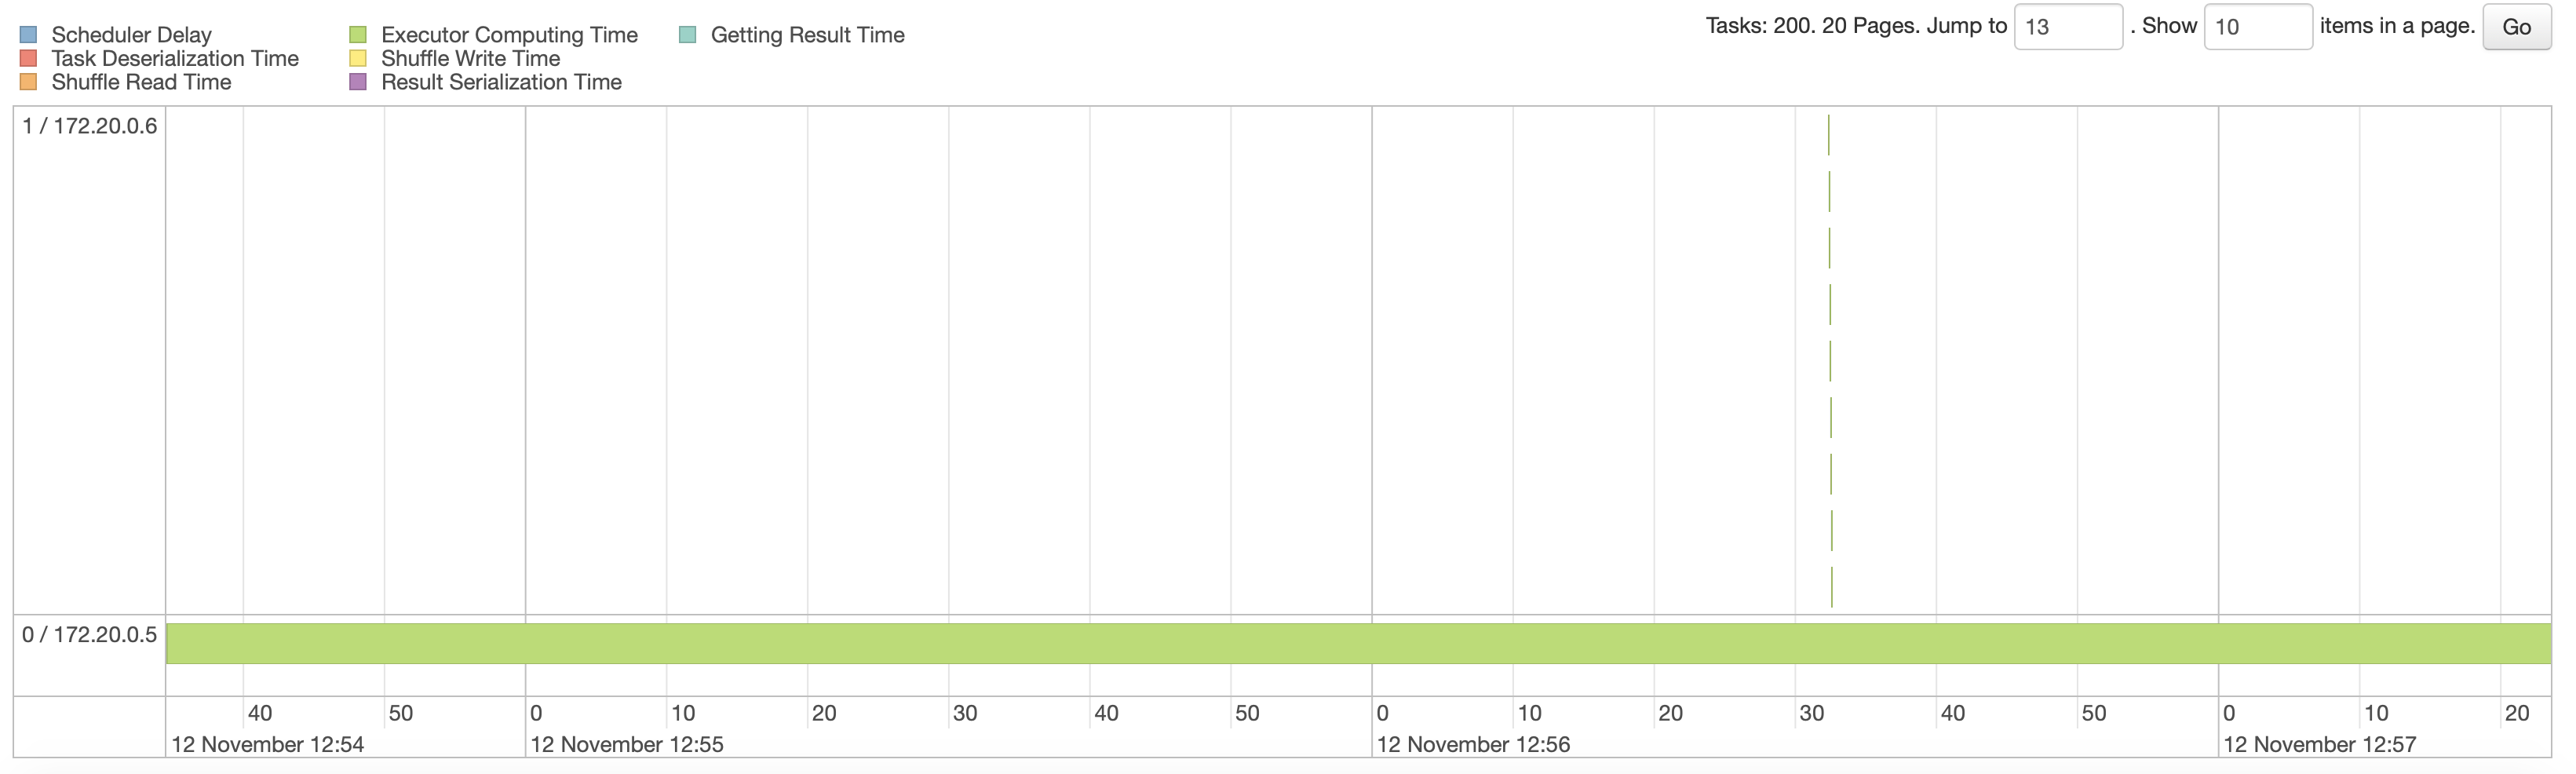

In [ ]:
spark.sql("SET spark.sql.autoBroadcastJoinThreshold=0")

df2 = meteo_df.where("yyyy>2015").where("observation_type in ('SNOW', 'TAVG')").join(observation_type_df,"observation_type", "inner")

#df2.explain(mode='formatted')

start_time = time.time()
df2.cache().count()
print(time.time() - start_time)
df2.unpersist()

#### 9.1 Broadcasting 

Using broadcast join if small table is small enough to fit into memory. It works fine, but is not possible for joining two big tables. 

In [ ]:
spark.sql("SET spark.sql.autoBroadcastJoinThreshold=10485760") # default value

df2 = meteo_df.where("yyyy>2015").where("observation_type in ('SNOW', 'TAVG')").join(observation_type_df,"observation_type", "inner")

df2.explain(mode='formatted')
start_time = time.time()
df2.cache().count()
print(time.time() - start_time)

df2.unpersist()
# we'll see one more solution for this skew example in the following section 

#### 9.2 Preprocessing 

Idea behind preprocessing is to eliminate partitions that cause skew by processing them separately. 

In [ ]:
skewed_df = (
    meteo_df
    .withColumn("country_code", F.col("station_identifier")[0:2])
    .where("yyyy>=2000")
    .where("observation_type='TAVG'")
    .where("country_code in ('US','MC','KU','KT','BA','CW','CB','CY','JN','CK')")
).repartition("country_code")

skewed_df.write.mode("overwrite").parquet("skewed")

In [ ]:
# if we do PRCP it's even more skewed
df = spark.read.parquet("skewed")

df2 = df.groupBy("country_code").avg("observation_value")

#df2.explain(mode='formatted')

start_time = time.time()
df2.cache().count()
print(time.time() - start_time)

df2.unpersist()

In [ ]:
# define which partition is that 
# obviously we don't include this step into production application 
df = spark.read.parquet("skewed")
df.where("yyyy=2000").groupBy("country_code").count().orderBy("count", ascending=False).show(10)

# in this case it's partitions with values US

# What we can try to do, is to remove the biggest partition and process it separately
df_part1 = df.where("country_code='US'").select(F.avg("observation_value")).withColumn("country_code", F.lit("US"))
df_part2 = df.where("country_code not in ('US')").groupBy("country_code").avg("observation_value")

df2 = df_part1.union(df_part2)

#df2.explain(mode='formatted')

start_time = time.time()
df2.cache().count()
print(time.time() - start_time)

df2.unpersist()

#### 9.3 Salting

How it works:

- We replicate the data in the small rdd N times by creating a new key (original_key, v) where v takes values between 0 and N. The value does not change, i.e. it is the same value that was associated to the original key.
- We take the large skewed rdd and modify the key to add some randomness by doing (original_key, random_int) where random_int takes a value between 0 and N. Note that in this case we are NOT replicating the data in the large rdd. We are simply splitting the keys so that values associated to the same original key are now split into N buckets.
- Finally, we perform the join between these datasets.
- We remove the random_int from the key to have the final result of the join.


In [ ]:
N = 5 # salting parameter to control replication 
df = spark.read.parquet("skewed")

df2 = (
    df
    .withColumn("country_code_mod", F.concat(F.col("country_code"), (F.rand()*N).cast('int')))
)
df3 = df2.groupBy("country_code_mod").avg("observation_value").withColumn("country_code", F.col("country_code_mod")[0:2]).groupBy(F.col("country_code_mod")[0:2]).avg("avg(observation_value)")

#df3.explain(mode='formatted')

start_time = time.time()
df3.cache().count()
print(time.time() - start_time)

df3.unpersist()

In [ ]:
N = 10 # salting parameter to control replication 
# create more keys 
df1 = (meteo_df
         .where("observation_type in ('SNOW', 'TAVG')")
         .where("yyyy>2015")
         .withColumn("observation_type_new", F.concat(F.col("observation_type"), (F.rand()*N).cast('int')))
      )
arr = [f"SNOW{n}" for n in range(1, N+1)] + [f"TAVG{n}" for n in range(1, N+1)] 
df_temp = (observation_type_df
                .where("observation_type in ('SNOW', 'TAVG')")
                .withColumn("tag_array", F.array([F.lit(x) for x in arr]))
                .withColumn("observation_type_new",  F.explode(F.col("tag_array")))
                .filter(F.col("observation_type_new").contains(F.col("observation_type")))
                .drop("tag_array")
          )
df2 = df1.join(df_temp,"observation_type_new", "left").drop("observation_type_new")
# df2.explain(mode='formatted')

start_time = time.time()
df2.cache().count()
print(time.time() - start_time)
df2.unpersist()

#### 9.4 Data skew optimisation in Spark 3.0

In Spark 3.0 the [data skew optimization](https://spark.apache.org/docs/latest/sql-performance-tuning.html#optimizing-skew-join) is added. It is controlled by the following settings:

1. `spark.sql.adaptive.skewJoin.enabled` -  it enables or disables the skew optimization
2. `spark.sql.adaptive.skewJoin.skewedPartitionFactor` - it controls the max size of non skewed partition
3. `spark.sql.adaptive.skewJoin.skewedPartitionThresholdInBytes` - value to checks whether a shuffle partition is skewed or not

If all settings are set correctly there are the following conditions when the skew join optimisation will be applied:
    
- the query has only 2 joins;
- the optimized plan doesn't involve an extra shuffle stage;
- join is a sort merge join for one of the supported types (inner, left outer, right outer, cross, left anti, left semi);
- both datasets have the same number of shuffle partitions;
- at least one of the sides have skews.
 
You can find the algorithtm, that is applied to optimize skew joins, by checking the source code.

[Here](https://www.waitingforcode.com/apache-spark-sql/whats-new-apache-spark-3-join-skew-optimization/read) is a good article with the explanation of optimisation algorithm

## Questions:
1. How `spark.sql.shuffle.partitions` affects performance of the job? Why too many shuffle partitions generate extra pressure on driver?
2. Why UDF's are slow in general? 
3. What is the benefit of using broadcast? 
4. Let's take the following query and try to optimise it.


In [ ]:
spark.sql("SET spark.sql.autoBroadcastJoinThreshold=0")

def station_zone(lt, lg):
    if (lt >=20 and lt<30) or (lt <=-20 and lt>-30): return "tropics"
    if (lt >-20 and lt<20):  return "equator" 
    if (lt >=30 and lt<40) or (lt <=-30 and lt>-40): return "subtropics"
    if (lt >=40 and lt<50) or (lt <=-40 and lt>-50): return "warm_temperate"
    if (lt >=50 and lt<60) or (lt <=-50 and lt>-60): return "boreal"
    if (lt >=60 and lt<70) or (lt <=-60 and lt>-70): return "tundra"
    if (lt >=75) or (lt <=-70): return "ice_cap"  

def decade(year):
    return year%10

spark.udf.register("station_zone", station_zone)
spark.udf.register("decade", decade)

meteo_df.join(stations_df, "station_identifier", "left").registerTempTable("meteo_table_ext")

df_udf = spark.sql("""
                    select 
                       station_identifier
                       , station_zone(latitude, longitude) as station_zone
                       , observation_type
                       , observation_value
                       , decade(yyyy) as decade
                    from 
                        meteo_table_ext
                    where yyyy>2000
                    
                """)
res = df_udf\
    .join(observation_type_df, "observation_type", "left")\
    .select("station_zone", "observation_type","description","observation_value")\
    .where("decade = 0")

# res.explain(mode='formatted')

res.repartition(10).write.format("parquet").mode("overwrite").save("res.parquet")

In [ ]:
# your code

In [ ]:
spark.stop()